In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#NLP Libraries
import nltk
import re
import string
from wordcloud import WordCloud, STOPWORDS


import warnings
warnings.filterwarnings('ignore')

In [55]:
real = pd.read_csv('True.csv')
fake = pd.read_csv('Fake.csv')

In [56]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


Renaming columns for better readabilty

In [57]:
real.columns = ['News_Title', 'News_Content', 'Domain', 'Publish_Date']
fake.columns = ['News_Title', 'News_Content', 'Domain', 'Publish_Date']

In [58]:
real['Fact_Check_Status'] = True

In [59]:
fake['Fact_Check_Status'] = False

In [60]:
#Concatinating the dataset and shuffling the values
data = pd.concat([real, fake], axis=0)

data = data.sample(frac=1).reset_index(drop=True)

In [61]:
data.head()

,News_Title,News_Content,Domain,Publish_Date,Fact_Check_Status
0,Boston Brakes? How to Hack a New Car With Your...,21st Century Wire says For those who still ref...,US_News,"January 22, 2016",False
1,CHURCHGOERS TRAPPED INSIDE CATHEDRAL After Man...,France s armed police officers were at least p...,left-news,"Jun 6, 2017",False
2,Trump says he will not negotiate on 20 percent...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"September 27, 2017",True
3,U.S. Interior Secretary investigated over spee...,WASHINGTON (Reuters) - The U.S. Office of Spec...,politicsNews,"October 3, 2017",True
4,"Factbox: Belgian mother of two, young New York...",(Reuters) - A New Jersey man who worked at the...,politicsNews,"November 1, 2017",True


# Preprocessing

Columns: News Content

In [62]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

data['News_Content'] = data['News_Content'].apply(clean_text)

Column: Publish_Date

In [63]:
data['Publish_Date'].unique()

array(['January 22, 2016', 'Jun 6, 2017', 'September 27, 2017 ', ...,
       'MSNBC HOST Rudely Assumes Steel Worker Would Never Let His Son Follow in His Footsteps…He Couldn’t Be More Wrong [Video]',
       'July 4, 2016 ', 'Jul 18, 2015'], dtype=object)

The above output helps us observe that there exixts a space after the year which needs to be dealt.

In [64]:
data['Publish_Date'] = data['Publish_Date'].str.strip()

In [65]:
data['Publish_Date'][:15]

,Publish_Date
0,"January 22, 2016"
1,"Jun 6, 2017"
2,"September 27, 2017"
3,"October 3, 2017"
4,"November 1, 2017"
5,"September 18, 2017"
6,"August 15, 2017"
7,"December 19, 2017"
8,"October 24, 2016"
9,"December 1, 2016"


After solving the problem of extra white space after the year column, there is one more formatting inconsistancy that is evidennt in the above output. Most of the months have been entered as whole whereas for some, they have used a three letter formatting.

In [66]:
# mapping of 3-letter abbreviations to full month names
abbr_to_full = {
    'Jan': 'January',
    'Feb': 'February',
    'Mar': 'March',
    'Apr': 'April',
    'May': 'May',
    'Jun': 'June',
    'Jul': 'July',
    'Aug': 'August',
    'Sep': 'September',
    'Oct': 'October',
    'Nov': 'November',
    'Dec': 'December'
}

for abbr, full in abbr_to_full.items():
    pattern = rf'^{abbr}\b'
    data['Publish_Date'] = data['Publish_Date'].str.replace(pattern, full, regex=True)

In [67]:
data['Publish_Date'] = pd.to_datetime(
    data['Publish_Date'],
    format='%B %d, %Y',
    errors='coerce'
).dt.date

In [68]:
data.head()

,News_Title,News_Content,Domain,Publish_Date,Fact_Check_Status
0,Boston Brakes? How to Hack a New Car With Your...,century wire says for those who still refuse ...,US_News,2016-01-22,False
1,CHURCHGOERS TRAPPED INSIDE CATHEDRAL After Man...,france s armed police officers were at least p...,left-news,2017-06-06,False
2,Trump says he will not negotiate on 20 percent...,washington reuters us president donald trump ...,politicsNews,2017-09-27,True
3,U.S. Interior Secretary investigated over spee...,washington reuters the us office of special c...,politicsNews,2017-10-03,True
4,"Factbox: Belgian mother of two, young New York...",reuters a new jersey man who worked at the wo...,politicsNews,2017-11-01,True


In [69]:
data['Publish_Date'].isnull().sum()

np.int64(45)

In [70]:
data['Publish_Date'][data['Publish_Date'].isnull()][:5]

,Publish_Date
1794,NaT
1861,NaT
2344,NaT
3444,NaT
3504,NaT


In [71]:
data.shape

(44898, 5)

In [74]:
#Removing the null values as the count is very small and wont affect the analysis
data.dropna(inplace = True)

In [75]:
data.shape

(44853, 5)

# Feature Engineering

In [76]:
data.head()

,News_Title,News_Content,Domain,Publish_Date,Fact_Check_Status
0,Boston Brakes? How to Hack a New Car With Your...,century wire says for those who still refuse ...,US_News,2016-01-22,False
1,CHURCHGOERS TRAPPED INSIDE CATHEDRAL After Man...,france s armed police officers were at least p...,left-news,2017-06-06,False
2,Trump says he will not negotiate on 20 percent...,washington reuters us president donald trump ...,politicsNews,2017-09-27,True
3,U.S. Interior Secretary investigated over spee...,washington reuters the us office of special c...,politicsNews,2017-10-03,True
4,"Factbox: Belgian mother of two, young New York...",reuters a new jersey man who worked at the wo...,politicsNews,2017-11-01,True


In [80]:
data.dtypes

,0
News_Title,object
News_Content,object
Domain,object
Publish_Date,object
Fact_Check_Status,bool


In [88]:
data['Publish_Date'] = pd.to_datetime(data['Publish_Date'])

## Feature 1: Extracting Month from Date

In [89]:
data['Publish_Month'] = data['Publish_Date'].dt.month

#Improving Readability
month_map = {
    1: 'Jan',  2: 'Feb',  3: 'Mar',  4: 'Apr',
    5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
data['Publish_Month'] = data['Publish_Month'].map(month_map)

## Feature 2: Extracing Publish Year from Publish Date

In [90]:
data['Publish_Year'] = data['Publish_Date'].dt.year

In [91]:
data.head()

,News_Title,News_Content,Domain,Publish_Date,Fact_Check_Status,Publish_Month,Publish_Year
0,Boston Brakes? How to Hack a New Car With Your...,century wire says for those who still refuse ...,US_News,2016-01-22,False,Jan,2016
1,CHURCHGOERS TRAPPED INSIDE CATHEDRAL After Man...,france s armed police officers were at least p...,left-news,2017-06-06,False,Jun,2017
2,Trump says he will not negotiate on 20 percent...,washington reuters us president donald trump ...,politicsNews,2017-09-27,True,Sep,2017
3,U.S. Interior Secretary investigated over spee...,washington reuters the us office of special c...,politicsNews,2017-10-03,True,Oct,2017
4,"Factbox: Belgian mother of two, young New York...",reuters a new jersey man who worked at the wo...,politicsNews,2017-11-01,True,Nov,2017


# Analysis

## Analysis on All Data

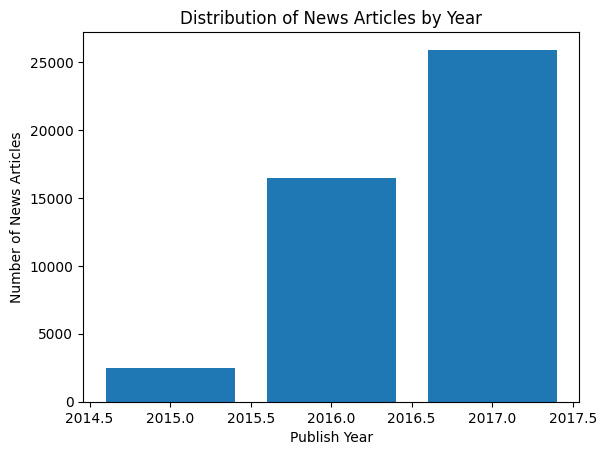

In [105]:
plt.bar(data['Publish_Year'].value_counts().index, data['Publish_Year'].value_counts())
plt.xlabel('Publish Year')
plt.ylabel('Number of News Articles')
plt.title('Distribution of News Articles by Year')
plt.show()

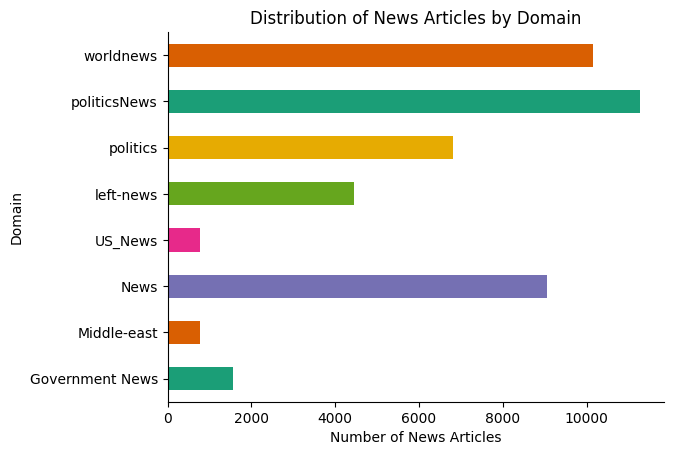

In [97]:
data.groupby('Domain').size(ascending=).plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('Number of News Articles')
plt.ylabel('Domain')
plt.title('Distribution of News Articles by Domain')
plt.show()

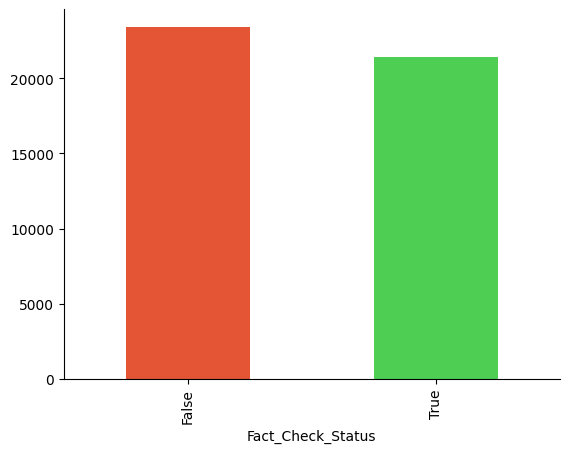

In [103]:
data.groupby('Fact_Check_Status').size().plot(kind='bar', color= ['#e35535', '#4fce54'])
plt.gca().spines[['top', 'right',]].set_visible(False)

In [106]:
def bar_univar(col):




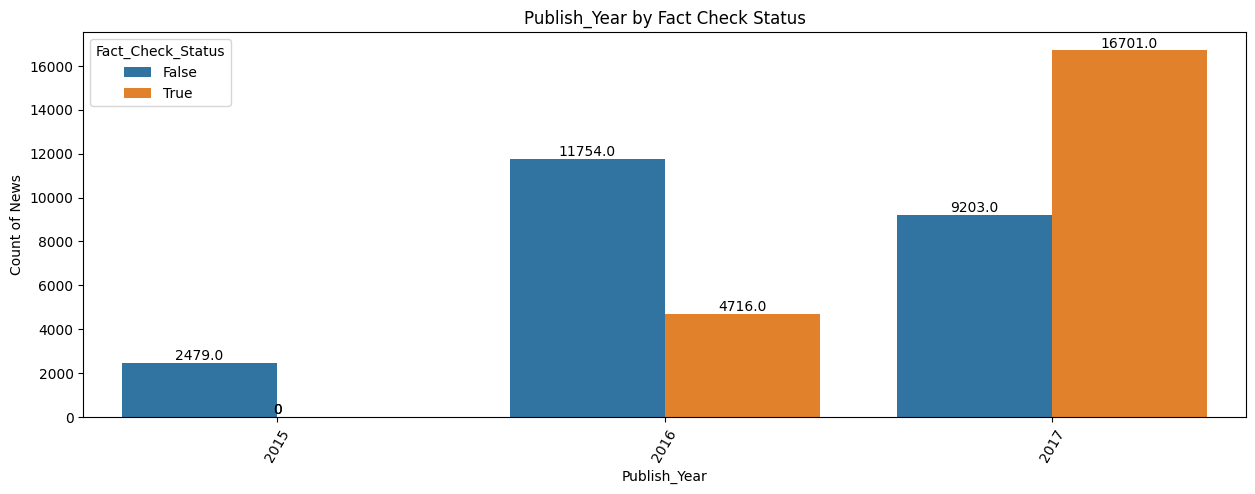

In [115]:
plt.figure(figsize=(15,5))
ax = sns.countplot(x= 'Publish_Year', hue= 'Fact_Check_Status', data = data)

#Annotate
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title("{} by Fact Check Status".format('Publish_Year'))
plt.xlabel('Publish_Year')
plt.ylabel("Count of News")
plt.xticks(rotation = 60)
plt.show()

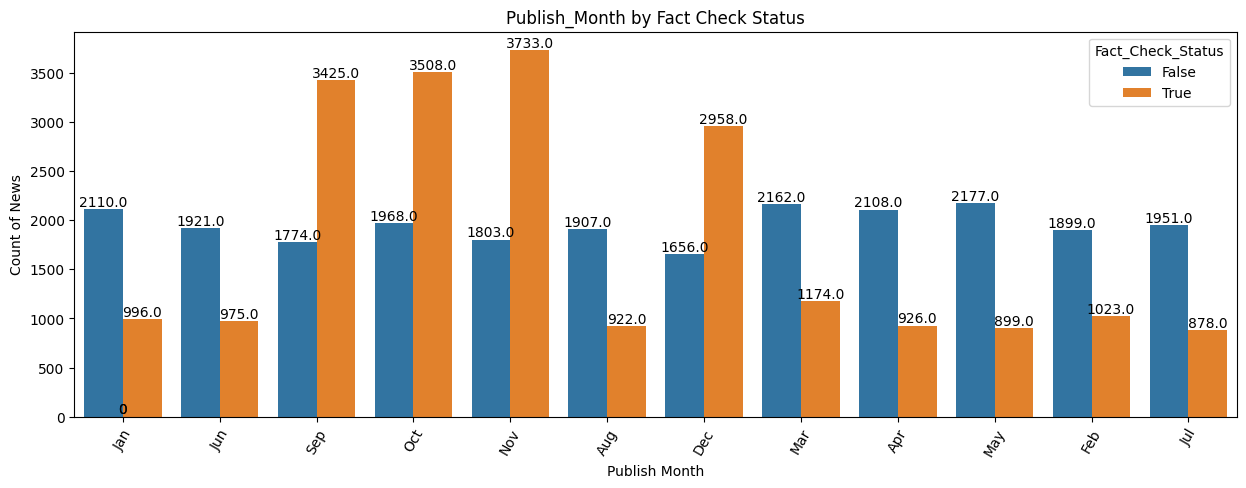

In [116]:
plt.figure(figsize=(15,5))
ax = sns.countplot(x= 'Publish_Month', hue= 'Fact_Check_Status', data = data)

#Annotate
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title("{} by Fact Check Status".format('Publish_Month'))
plt.xlabel('Publish Month')
plt.ylabel("Count of News")
plt.xticks(rotation = 60)
plt.show()

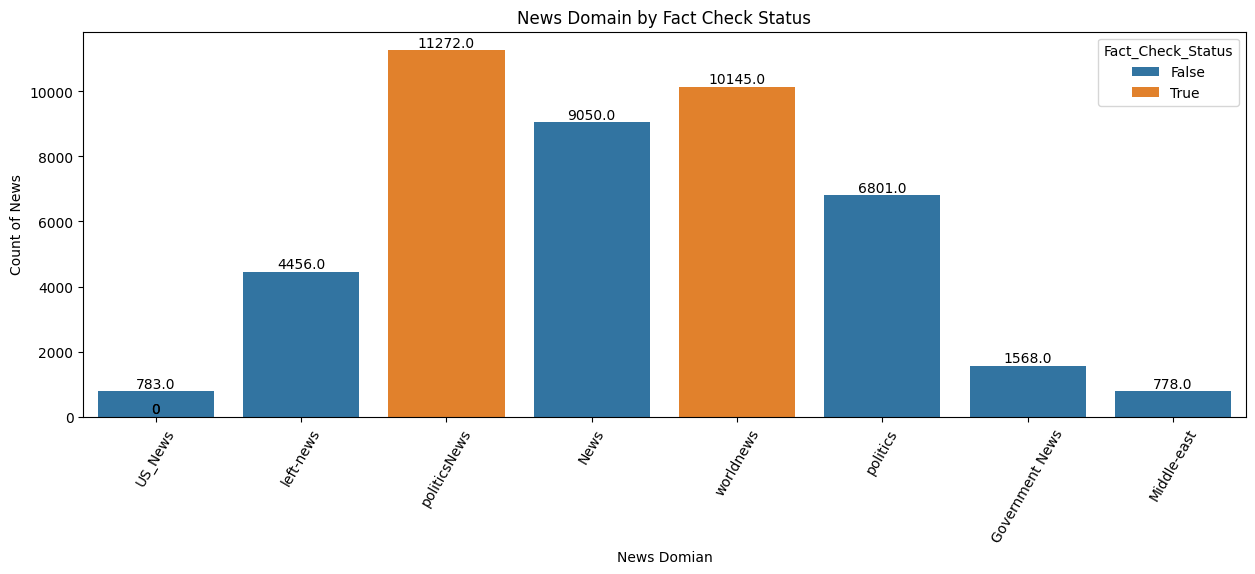

In [117]:
plt.figure(figsize=(15,5))
ax = sns.countplot(x= 'Domain', hue= 'Fact_Check_Status', data = data)

#Annotate
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title("{} by Fact Check Status".format('News Domain'))
plt.xlabel('News Domian')
plt.ylabel("Count of News")
plt.xticks(rotation = 60)
plt.show()

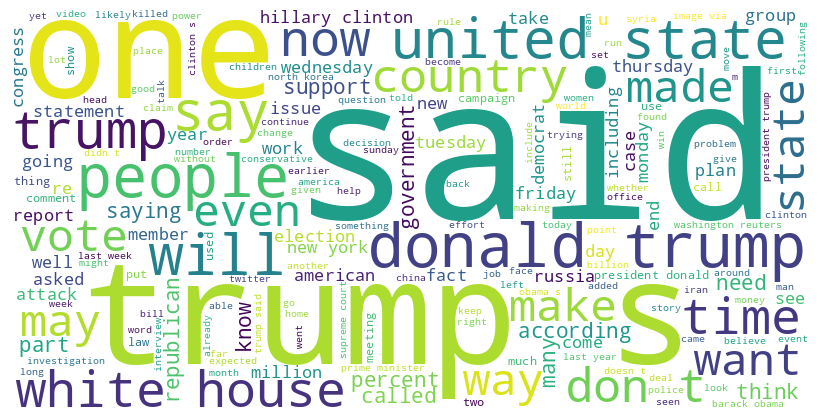

In [121]:
def plot_wordcloud(text):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          stopwords=stopwords,
                          min_font_size=10).generate(text)

    # plot the WordCloud image
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

all_news_content = " ".join(data['News_Content'].astype(str).tolist())
plot_wordcloud(all_news_content)

### Analysis of True News

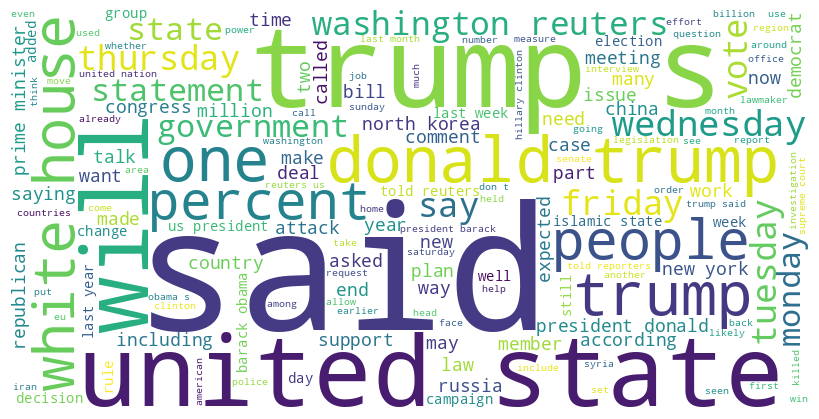

In [122]:
true_news_content = " ".join(data[data['Fact_Check_Status'] == True]['News_Content'].astype(str).tolist())
plot_wordcloud(true_news_content)

### Analysis of Fake News

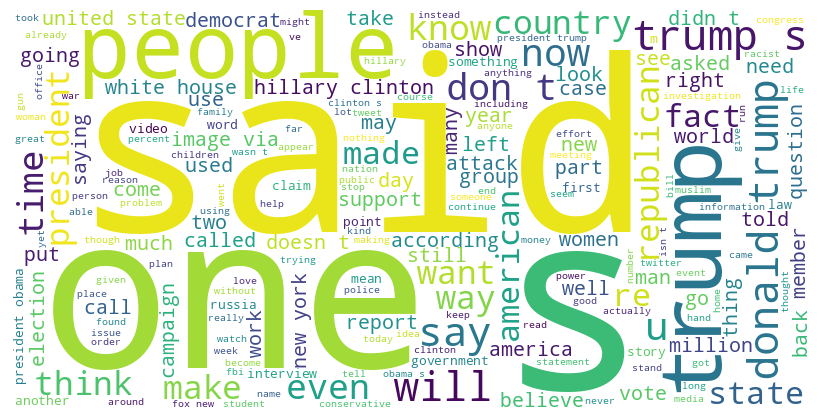

In [123]:
fake_news_content = " ".join(data[data['Fact_Check_Status'] == False]['News_Content'].astype(str).tolist())
plot_wordcloud(fake_news_content)